In [1]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/kaggle/input/plane-crash/planecrashinfo_20181121001952.csv")

In [3]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['year'] = data['date'].dt.year

data['fatalities'] = data['fatalities'].astype(str)
data['aboard'] = data['aboard'].astype(str)

data['fatalities'] = data['fatalities'].str.split().str[0]
data['fatalities'] = pd.to_numeric(data['fatalities'], errors='coerce')

data['aboard'] = data['aboard'].str.split().str[0]
data['aboard'] = pd.to_numeric(data['aboard'], errors='coerce')

data = data.dropna(subset=['year', 'fatalities', 'aboard'])
data = data[data['fatalities'] > 0]
data = data[data['aboard'] > 0]



data['fatality_rate'] = data['fatalities'] / data['aboard']

yearly_data = data.groupby('year').agg({
    'fatalities': ['mean', 'sum'],
    'fatality_rate': 'mean'
}).reset_index()



yearly_data.columns = ['year', 'avg_fatalities', 'total_fatalities', 'avg_fatality_rate']

yearly_data.head(20)

,year,avg_fatalities,total_fatalities,avg_fatality_rate
0,1908,1.000000,1.0,0.500000
1,1909,1.000000,1.0,1.000000
2,1912,5.000000,5.0,1.000000
3,1913,15.000000,45.0,0.900000
4,1915,20.000000,40.0,0.756098
5,1916,21.600000,108.0,0.992857
6,1917,19.714286,138.0,0.982143
7,1918,16.250000,65.0,1.000000
8,1919,2.857143,20.0,1.000000
9,1920,1.388889,25.0,0.888889


Plot 1: Average Fatalities per Crash per Year

(1920.0, 2020.0)

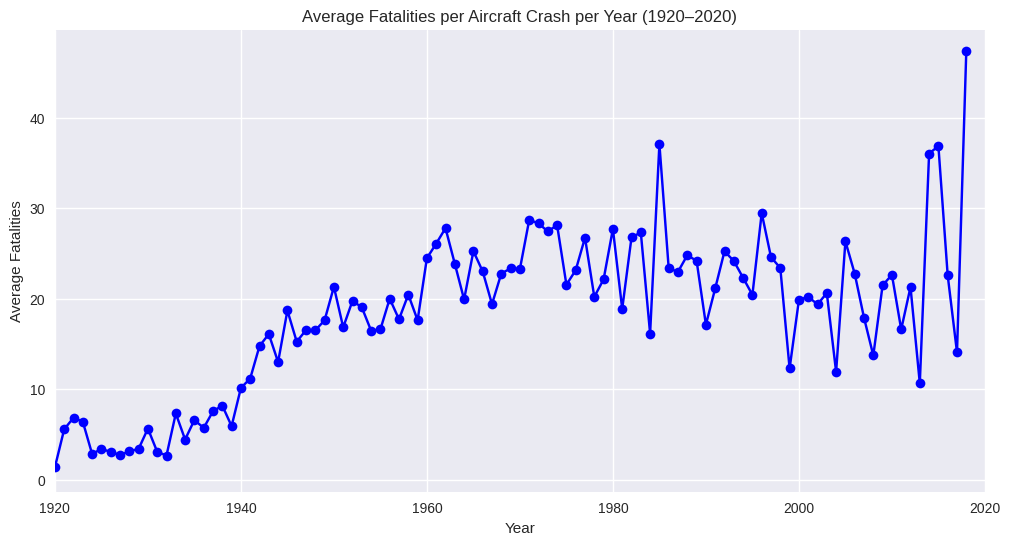

In [4]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
plt.plot(yearly_data['year'], yearly_data['avg_fatalities'], marker='o', color='blue')
plt.title('Average Fatalities per Aircraft Crash per Year (1920–2020)')
plt.xlabel('Year')
plt.ylabel('Average Fatalities')
plt.grid(True)
plt.savefig('avg_fatalities_per_year.png')
plt.xlim(1920, 2020)


Plot 2: Average Fatality Rate per Crash per Year

(1919.0, 2020.0)

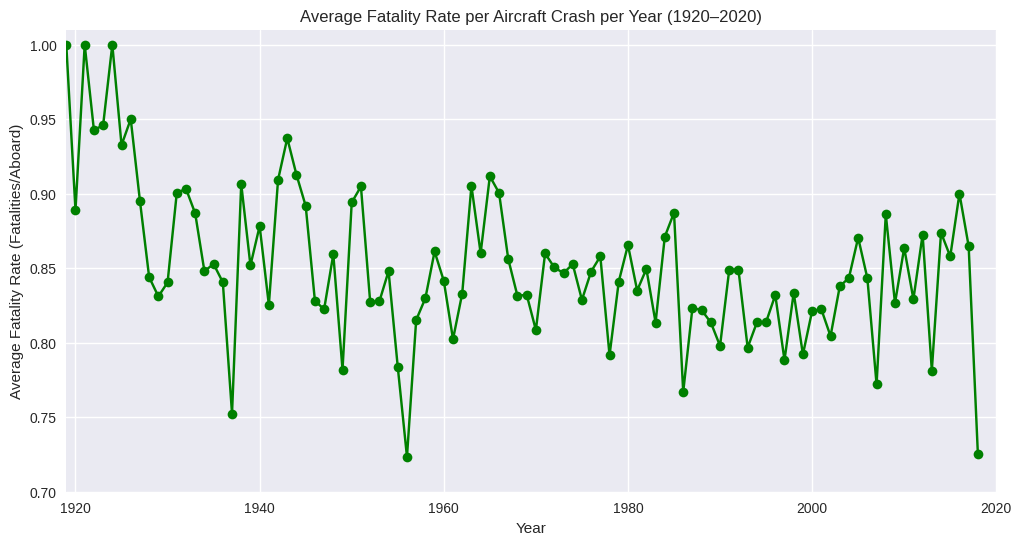

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(yearly_data['year'], yearly_data['avg_fatality_rate'], marker='o', color='green')
plt.title('Average Fatality Rate per Aircraft Crash per Year (1920–2020)')
plt.xlabel('Year')
plt.ylabel('Average Fatality Rate (Fatalities/Aboard)')
plt.ylim(0.7, 1.01)
plt.grid(True)
plt.savefig('avg_fatality_rate_per_year.png')
plt.xlim(1919, 2020)

Plot 3: Failure-Related Words in Crash Summaries

,pilot,flight,engine,fire,landing,control,fuel,weather,power,hydraulic
Year,,,,,,,,,,
1908,0,2,0,0,0,1,0,0,0,0
1909,1,0,0,0,0,0,0,0,0,0
1912,0,1,0,0,0,0,0,0,0,0
1913,0,0,1,0,0,1,0,0,0,0
1915,0,0,0,0,0,0,0,0,0,0
1916,0,0,0,1,0,0,0,0,0,0
1917,0,0,0,3,0,0,0,0,0,0
1918,0,0,0,0,0,1,0,0,0,0
1919,3,2,0,1,1,0,0,1,0,0


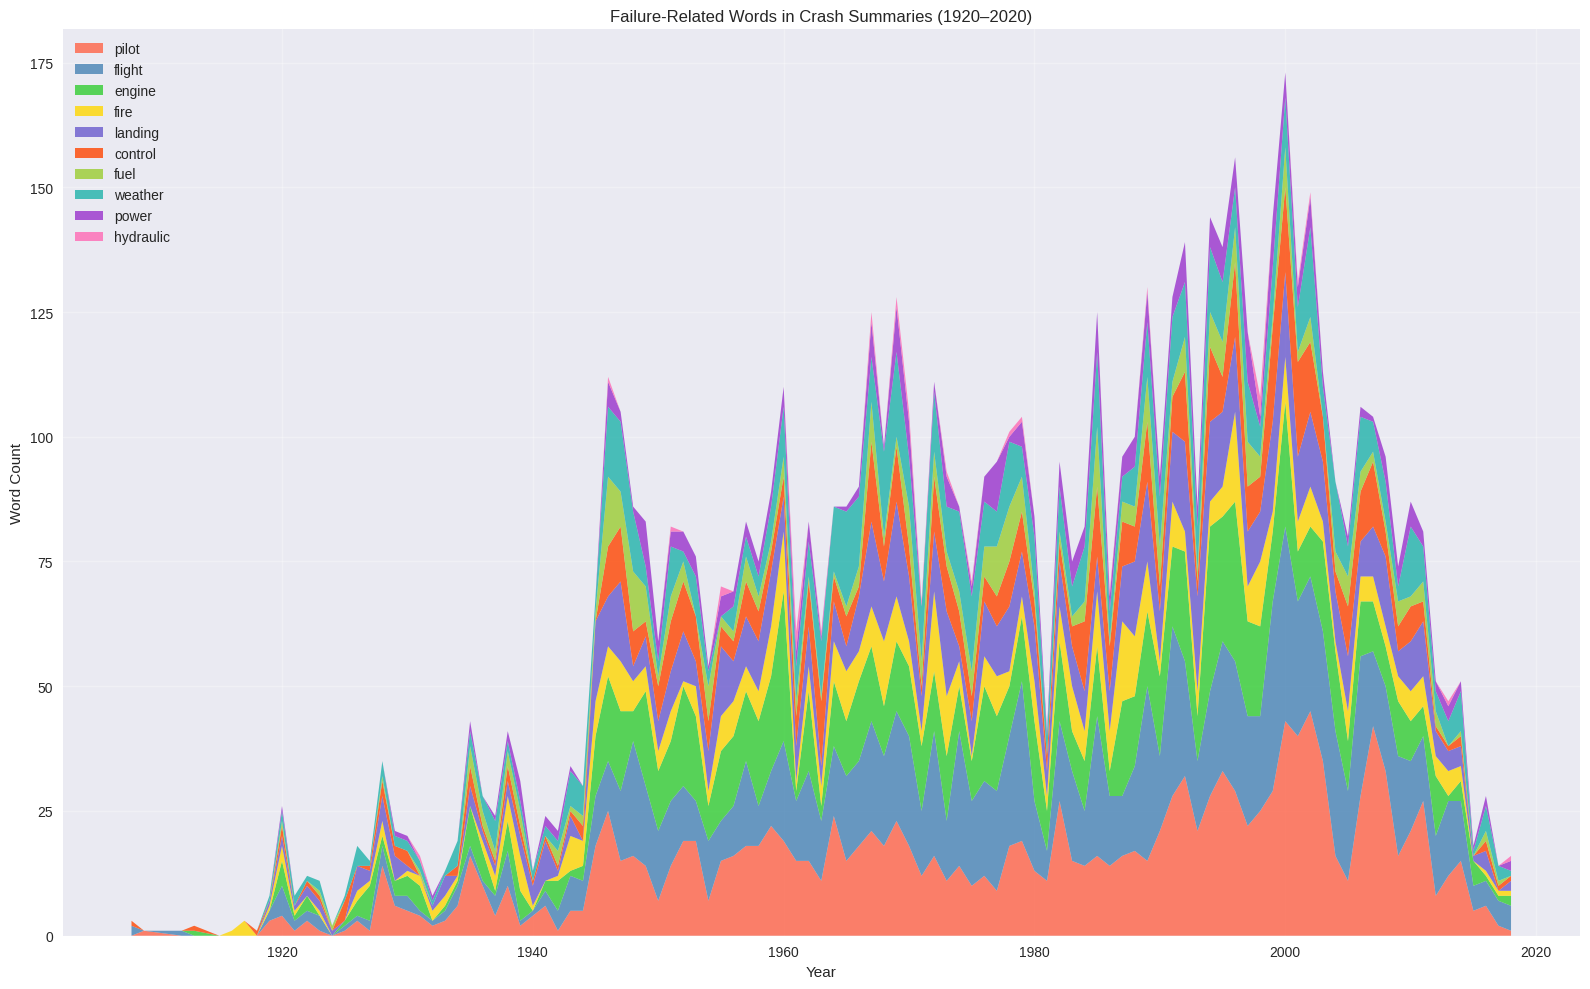

In [6]:
data = data.dropna(subset=['year', 'summary'])

data = data[(data['year'] >= 1908) & (data['year'] <= 2018)]

stopwords = {
    'the', 'and', 'in', 'of', 'to', 'a', 'was', 'on', 'at', 'for', 'with', 'by', 'from',
    'after', 'while', 'during', 'into', 'an', 'as', 'were', 'had', 'but', 'or', 'when',
    'which', 'that', 'is', 'it', 'be', 'been', 'this', 'its', 'their', 'they', 'he', 'she'
}

top_words = ['pilot', 'flight', 'engine', 'fire', 'landing', 'control', 'fuel', 'weather', 'power', 'hydraulic']

years = sorted(data['year'].unique())
year_counts = {word: [] for word in top_words}

for year in years:
    year_data = data[data['year'] == year]['summary'].str.lower()
    word_counter = Counter()
    for summary in year_data:
        words = re.findall(r'\b\w+\b', summary)
        filtered_words = [word for word in words if word not in stopwords]
        word_counter.update(filtered_words)
    for word in top_words:
        year_counts[word].append(word_counter.get(word, 0))

# Create a DataFrame for counts
count_df = pd.DataFrame(year_counts, index=years)
count_df.index.name = 'Year'

plt.figure(figsize=(16, 10))
colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#6A5ACD', '#FF4500', '#9ACD32', '#20B2AA', '#9932CC', '#FF69B4']
plt.stackplot(years, [count_df[word] for word in top_words], labels=top_words, colors=colors, alpha=0.8)
plt.title('Failure-Related Words in Crash Summaries (1920–2020)')
plt.xlabel('Year')
plt.ylabel('Word Count')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

count_df.head(20)